In [48]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.io import loadmat

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

from typing import List
from tqdm import tqdm

In [89]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rc('font', family='serif', serif="cmr10", size=16)
plt.rc('mathtext', fontset='cm', rm='serif')
plt.rc('axes', unicode_minus=False)

In [ ]:
# loading the graph in networkx
PPI_data = loadmat('./datasets/PPI/Homo_sapiens.mat')
G = nx.from_scipy_sparse_array(PPI_data['network'])

In [ ]:
# export for node2vec
nx.write_edgelist(G, './node2vec/graph/ppi.edgelist')
# running node2vec
!python node2vec/src/main.py --input ./node2vec/graph/ppi.edgelist --output ./node2vec/emb/ppi.emb

In [31]:
with open('./node2vec/emb/ppi.emb', 'r') as handle:
    (n, d) = map(int, handle.readline().strip().split())

    X = np.empty((n, d), dtype=np.float32)
    while (line := handle.readline().strip()):
        (idx, *emb) = line.split()
        X[int(idx)] = list(map(float, emb))
# loading the multi-label data
y = PPI_data['group'].toarray()

In [32]:
y.shape

(3890, 50)

In total there are 3890 nodes that can belong to (multiple) of any of the 50 classes.

In [33]:
# avg. no. classes per node
y.sum(axis=1).mean()

1.7069408740359897

In [94]:
def cross_validate_f1(
    X: List[List[float]], 
    y: List[List[int]], 
    folds: int=10, 
    verbose: bool=True
) -> List[float] :
    # macro-f1 cv on logistic 1-vs-rest logistic regression
    
    clf = OneVsRestClassifier(LogisticRegression(penalty='l2'), n_jobs=-1)
    kf = KFold(n_splits=folds, shuffle=True)
    f1 = []
    for j, (train_index, test_index) in enumerate(kf.split(X)) :
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        f1.append(f1_score(y_test, y_pred, average='macro', zero_division=0))
        if (verbose) : print(f'[{j+1:02d}/{folds:02d}] {f1[-1]:.5f}')
    if (verbose) : print(f'mean: {np.mean(f1):.5f}')
    return np.array(f1)

In [95]:
f1_baseline = cross_validate_f1(X, y);

[01/10] 0.07043
[02/10] 0.04462
[03/10] 0.06245
[04/10] 0.06144
[05/10] 0.07401
[06/10] 0.04842
[07/10] 0.06807
[08/10] 0.10190
[09/10] 0.06921
[10/10] 0.05896
mean: 0.06595


In [28]:
def diffuse_embeddings(G: nx.Graph, X: List[List[float]], gamma=0.05) -> List[List[float]] :
    # diffusing the learned embeddings based on their neighbors
    deg_avg = sum(d for (n, d) in G.degree()) / G.number_of_nodes()

    Xprime = X.copy()
    for u in G.nodes() : 
        for v in G.neighbors(u) : 
            Xprime[u] += gamma*(G.degree(v)/deg_avg)*X[v]
    return Xprime

In [83]:
n = 13 # no. gamma variations
folds = 10 # cv folds

gammas = np.logspace(-3,1,n)
f1_diffused = np.empty((n, folds), dtype=np.float32)

for (j, gamma) in tqdm(enumerate(gammas), total=n) :
    Xprime = diffuse_embeddings(G, X, gamma,)
    f1_diffused[j] = cross_validate_f1(Xprime, y,  verbose=False)

100%|██████████| 13/13 [02:24<00:00, 11.15s/it]


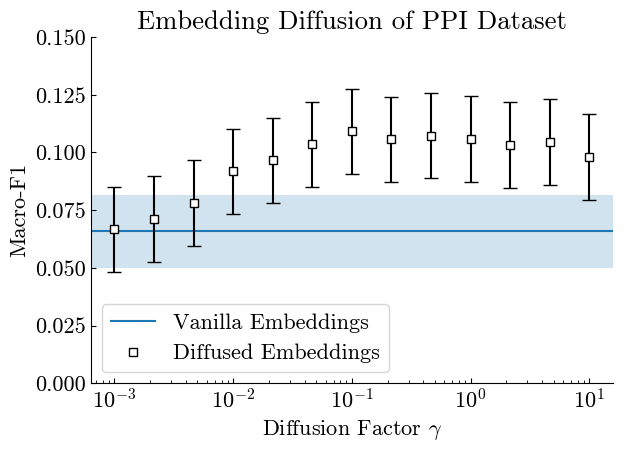

In [98]:
fig, ax = plt.subplots()

(m_baseline, sd_baseline) = (np.mean(f1_baseline), np.std(f1_baseline, ddof=1))

ax.axhspan(m_baseline - sd_baseline, m_baseline + sd_baseline, alpha=0.2)
ax.axhline(np.mean(f1_baseline), label='Vanilla Embeddings')

ax.errorbar(gammas, f1_diffused.mean(axis=1), yerr=f1_diffused.std(ddof=1), capsize=5, ls='none', c='k')
ax.semilogx(gammas, f1_diffused.mean(axis=1), 'ks', mfc='w', label='Diffused Embeddings')

ax.set_ylim(0, 0.15)
ax.set_ylabel('Macro-F1')
ax.set_xlabel('Diffusion Factor $\gamma$')

ax.legend()
ax.set_title('Embedding Diffusion of PPI Dataset')

fig.tight_layout()

In [96]:
f1_baseline.max(), f1_diffused.max()

(0.10189953882833142, 0.13973388)

In [97]:
f1_baseline.mean(), f1_diffused.mean(axis=1).max()

(0.065951057563704, 0.109211825)